In [6]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import itertools
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R
from functools import partial
import json
import matplotlib.pyplot as plt

# Make matplotlib interractive in jupyter
%matplotlib widget

# TODO clean up notebook and add docstrings

/var/folders/md/st78sm6x1jz1y3tb7d13707c0000gn/T/ipykernel_26908/3605010157.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3))


Number of measurements: 15


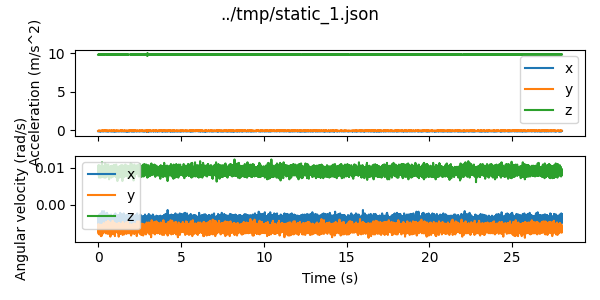

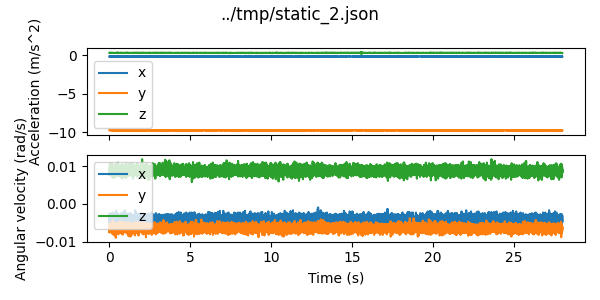

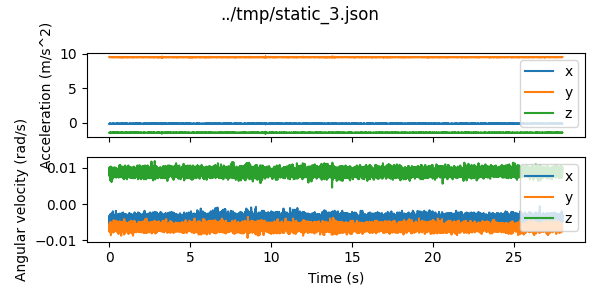

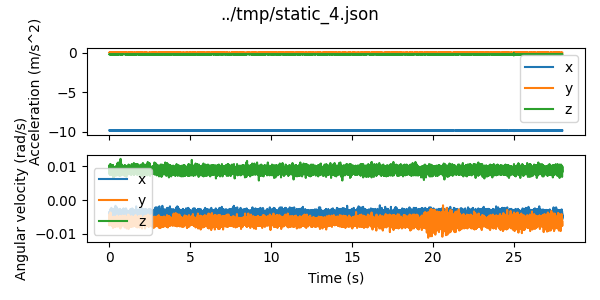

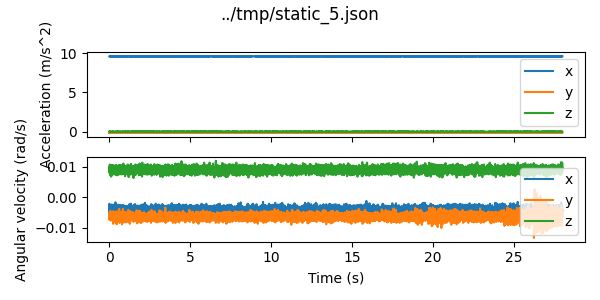

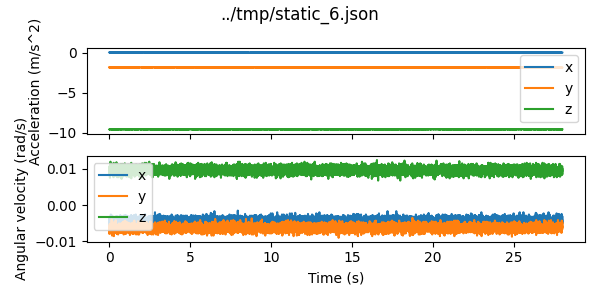

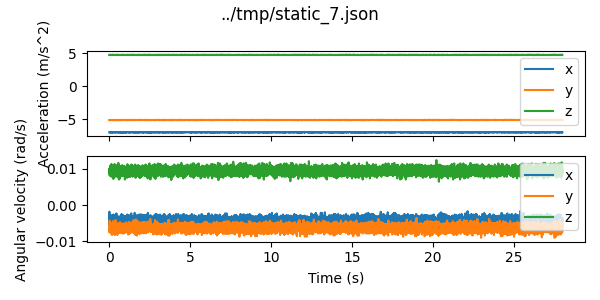

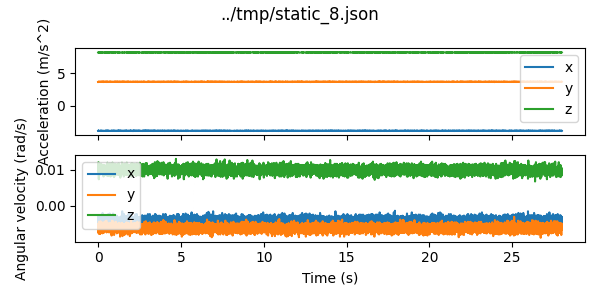

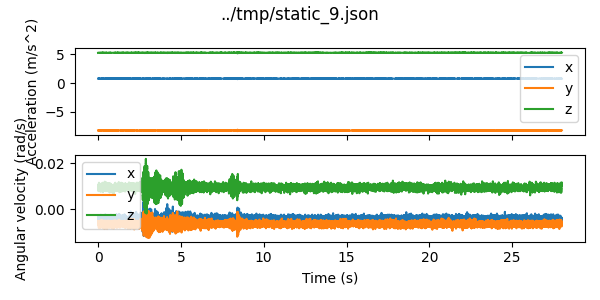

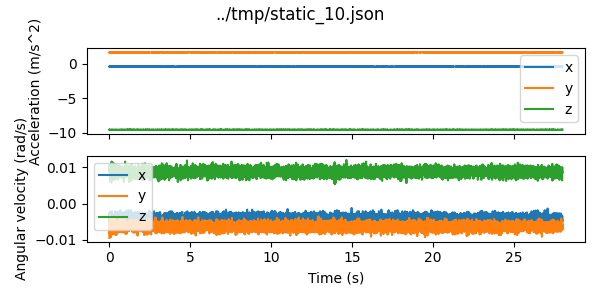

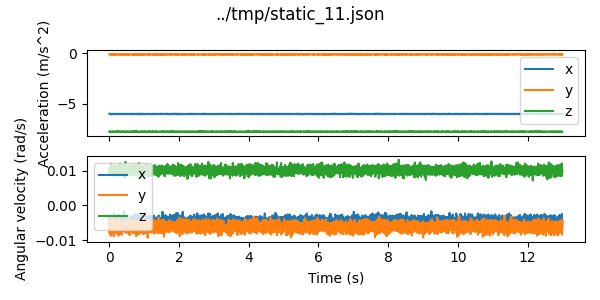

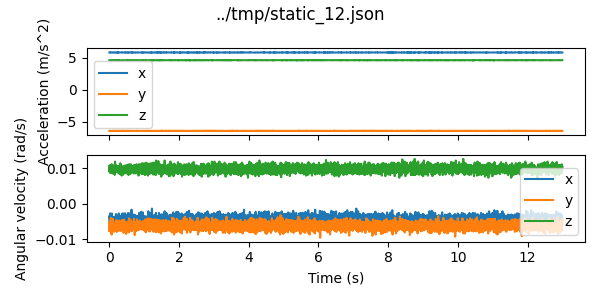

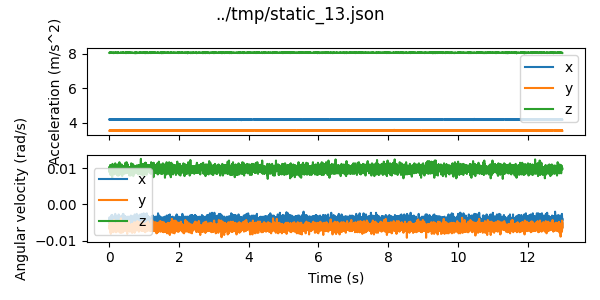

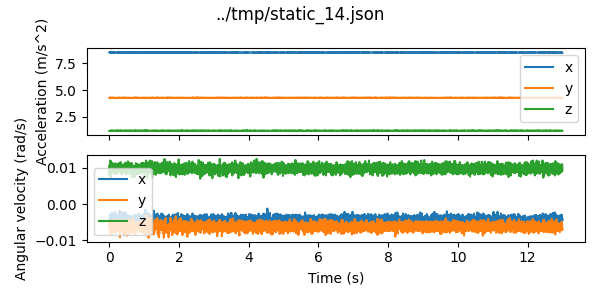

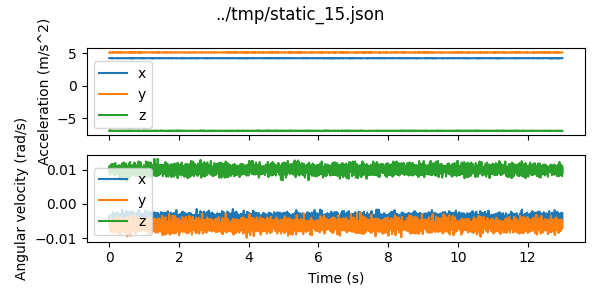

In [7]:
ACCELEROMETER_SCALE = 1.000576332
# Degrees to radian
GYROSCOPE_SCALE = 2*np.pi/360
# Target G is based on longitude, latitude, and elevation (https://geodesy.noaa.gov/cgi-bin/grav_pdx.prl)
TARGET_G = 9.80339

def run_butter_filter(in_signal, sample_rate, highpass=None, lowpass=None, order=2):
    if lowpass is None and highpass is not None:
        filter_cutoff = [highpass]
        f_type = 'highpass'
    elif highpass is None and lowpass is not None:
        filter_cutoff = [lowpass]
        f_type = 'lowpass'
    elif highpass is not None and lowpass is not None:
        filter_cutoff = [highpass, lowpass]
        f_type = 'bandpass'
    else:
        raise NotImplementedError

    sos = signal.butter(order, filter_cutoff, f_type, fs=sample_rate, output='sos')
    return signal.sosfiltfilt(sos, in_signal)


def get_file_stats(file, cut_time=2, plot=False):
    with open(file) as f:
        data = json.load(f)
    accelerometer = np.array(data['accelerometer'])*ACCELEROMETER_SCALE
    gyroscope = np.array(data['gyro'])*GYROSCOPE_SCALE
    sample_rate = 417

    # Filter the accelerometer data
    accelerometer[:, 0] = run_butter_filter(accelerometer[:, 0], sample_rate, lowpass=150, order=3)
    accelerometer[:, 1] = run_butter_filter(accelerometer[:, 1], sample_rate, lowpass=150, order=3)
    accelerometer[:, 2] = run_butter_filter(accelerometer[:, 2], sample_rate, lowpass=150, order=3)

    # Remove first seconds of data
    cut_time = 2
    accelerometer = accelerometer[int(sample_rate*cut_time):]
    gyroscope = gyroscope[int(sample_rate*cut_time):]

    if plot:
        plot_imu(accelerometer, gyroscope, sample_rate, file)
    
    # Combine into a single measurement vector
    measurements = np.hstack((accelerometer, gyroscope))
    # Calculate mean and covariance
    return np.mean(measurements, axis=0), np.cov(measurements, rowvar=False)


def plot_imu(accelerometer, gyro, sample_rate, title=None):
    # Plot the accelerometer data in one subplot and the gyro data in another with shared x axis, time axis has a sample rate of 417 Hz
    t = np.arange(len(accelerometer)) / sample_rate
    accelerometer = np.array(accelerometer)
    gyro = np.array(gyro)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3))
    if title is not None:
        fig.suptitle(title)
    ax1.plot(t, accelerometer[:, 0], label='x')
    ax1.plot(t, accelerometer[:, 1], label='y')
    ax1.plot(t, accelerometer[:, 2], label='z')
    ax1.set_ylabel('Acceleration (m/s^2)')
    ax1.legend()
    ax2.plot(t, gyro[:, 0], label='x')
    ax2.plot(t, gyro[:, 1], label='y')
    ax2.plot(t, gyro[:, 2], label='z')
    ax2.set_ylabel('Angular velocity (rad/s)')
    ax2.set_xlabel('Time (s)')
    ax2.legend()
    fig.tight_layout()

a_mean_list = []
g_mean_list = []
cov_list = []
for i in range(1, 16):
    mean_f, cov_f = get_file_stats(os.path.join('..', 'tmp', f'static_{i}.json'), plot=True)
    a_mean_list.append(mean_f[:3])
    g_mean_list.append(mean_f[3:])
    cov_list.append(cov_f)
print(f"Number of measurements: {len(a_mean_list)}")


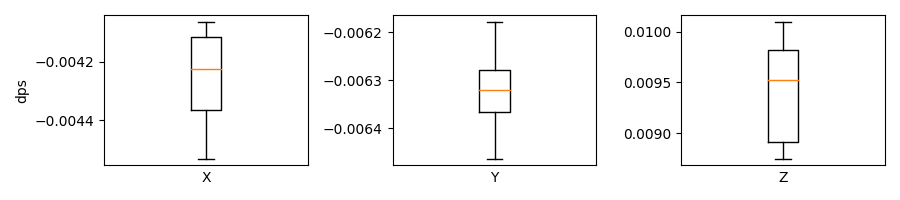

X: -0.00 ± 0.00 dps
Y: -0.01 ± 0.00 dps
Z: 0.01 ± 0.00 dps


In [8]:
# Plot box plots for gyroscope offsets
x, y, z = np.array(g_mean_list).T
data = [x, y, z]
labels = ['X', 'Y', 'Z']
fig, axs = plt.subplots(1, 3, figsize=(9, 2))
for i, (ax, label, axis_data) in enumerate(zip(axs, labels, data)):
    ax.boxplot(axis_data)
    ax.set_xlabel(f'{label}')
    if i == 0:
        ax.set_ylabel('dps')
    ax.set_xticks([])  # Remove x-axis ticks since there's only one box per subplot
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

# Print mean +/- STD for the gyroscope offsets
print(f'X: {np.mean(x):.2f} ± {np.std(x):.2f} dps')
print(f'Y: {np.mean(y):.2f} ± {np.std(y):.2f} dps')
print(f'Z: {np.mean(z):.2f} ± {np.std(z):.2f} dps')

final_gyroscope_offset = np.mean(g_mean_list, axis=0)

In [9]:
def get_offset(a_mean_list):
    def _simulate_norm(a_mean_list, c):
        sensitivity = c[0]
        offset = c[1:]
        errors = []
        for a_mean in a_mean_list:
            v = np.linalg.norm(a_mean*sensitivity - offset)
            errors.append(v - TARGET_G)

        return np.sqrt(np.mean(np.array(errors)**2))

    # Get a partial function from simulate vector where we fix the acceleration vectors
    simulate_norm_partial = partial(_simulate_norm, a_mean_list)

    # Run the optimizer using
    res = minimize(simulate_norm_partial, np.zeros(4), tol=1e-6)
    sensitivity_norm = res.x[0]
    offset_norm = res.x[1:]
    return sensitivity_norm, offset_norm

sensitivity, offset = get_offset(a_mean_list)
print(f'Sensitivity: {sensitivity}')
print(f'Offset: {offset}')
print()
final_accelerometer_offset = offset
final_accelerometer_sensitivity = sensitivity

Sensitivity: 1.0069203682170857
Offset: [-0.09790758 -0.08112766  0.03683966]



,recording_count,x_mean,x_std,y_mean,y_std,z_mean,z_std,se_mean,se_std
0,5,-0.096112,0.041286,-0.077414,0.052282,0.037628,0.041356,1.006952,0.002808
1,6,-0.099991,0.027722,-0.084143,0.040618,0.039557,0.030467,1.006753,0.002133
2,7,-0.100166,0.021385,-0.078045,0.033326,0.039405,0.025072,1.006985,0.001777
3,8,-0.096104,0.017894,-0.080104,0.028427,0.036931,0.018625,1.006791,0.001333
4,9,-0.098457,0.014222,-0.082644,0.024438,0.038559,0.016195,1.006903,0.001057
5,10,-0.098847,0.010342,-0.081940,0.020941,0.037147,0.012598,1.006828,0.000873
6,11,-0.097733,0.008084,-0.079536,0.018555,0.036258,0.008482,1.006817,0.000718
7,12,-0.097418,0.006653,-0.081934,0.013812,0.036847,0.007978,1.006931,0.000595
8,13,-0.097929,0.005094,-0.081106,0.011520,0.036885,0.006057,1.006906,0.000445
9,14,-0.097920,0.003349,-0.081115,0.007817,0.036857,0.004018,1.006913,0.000296


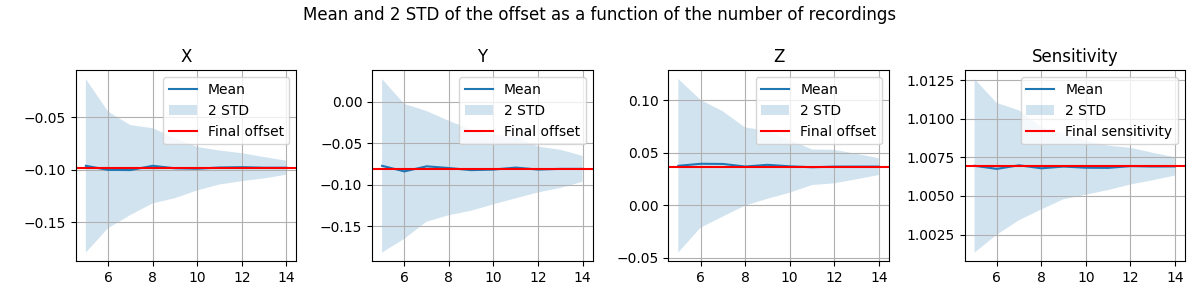

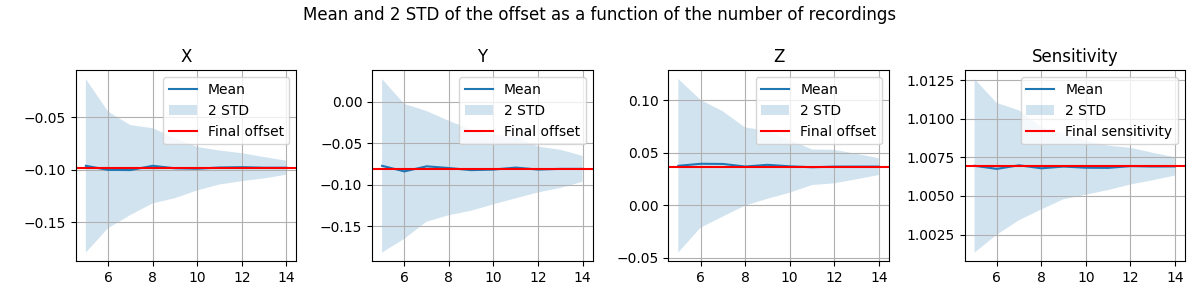

In [10]:
def bootstrap(a_mean_list, n):
    combinations = list(itertools.combinations(a_mean_list, n))
    max_combinations = 200
    if len(combinations) > max_combinations:
        # Get max_combinations random indices
        indices = np.random.choice(len(combinations), max_combinations, replace=False)
        combinations = [combinations[i] for i in indices]

    offset_list = []
    sensitivity_list = []
    for sub_a_mean_list in combinations:
        sensitivity, offset = get_offset(sub_a_mean_list)
        offset_list.append(offset)
        sensitivity_list.append(sensitivity)
    sensitivity_list = np.array(sensitivity_list)
    offset_list = np.array(offset_list)
    
    return np.mean(sensitivity_list), np.std(sensitivity_list), np.mean(offset_list, axis=0), np.std(offset_list, axis=0)


recording_counts = list(range(5, len(a_mean_list)))
offset_mean_list = []
offset_std_list = []
sensitivity_mean_list = []
sensitivity_std_list = []
for n in recording_counts:
    sensitivity_mean, sensitivity_std, offset_mean, offset_std = bootstrap(a_mean_list, n)
    offset_mean_list.append(offset_mean)
    offset_std_list.append(offset_std)
    sensitivity_mean_list.append(sensitivity_mean)
    sensitivity_std_list.append(sensitivity_std)
recording_counts = np.array(recording_counts)
offset_mean_list = np.array(offset_mean_list)
offset_std_list = np.array(offset_std_list)
sensitivity_mean_list = np.array(sensitivity_mean_list)
sensitivity_std_list = np.array(sensitivity_std_list)

# Create a dataframe from the recording count, mean list and std list
columns = ['recording_count', 'x_mean', 'x_std', 'y_mean', 'y_std', 'z_mean', 'z_std', 'se_mean', 'se_std']
df = pd.DataFrame({
    'recording_count': recording_counts,
    'x_mean': offset_mean_list[:, 0], 'x_std': offset_std_list[:, 0],
    'y_mean': offset_mean_list[:, 1], 'y_std': offset_std_list[:, 1],
    'z_mean': offset_mean_list[:, 2], 'z_std': offset_std_list[:, 2],
    'se_mean': sensitivity_mean_list, 'se_std': sensitivity_std_list,
})
display(df)

# Plot line for mean with shaded regions +/- 2 STD
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(recording_counts, offset_mean_list[:, 0], label='Mean')
ax[0].fill_between(recording_counts, offset_mean_list[:, 0] - 2*offset_std_list[:, 0], offset_mean_list[:, 0] + 2*offset_std_list[:, 0], alpha=0.2, label='2 STD')
ax[0].axhline(final_accelerometer_offset[0], color='r', label='Final offset')
ax[0].set_title('X')
ax[0].legend()
ax[0].grid()
ax[1].plot(recording_counts, offset_mean_list[:, 1], label='Mean')
ax[1].fill_between(recording_counts, offset_mean_list[:, 1] - 2*offset_std_list[:, 1], offset_mean_list[:, 1] + 2*offset_std_list[:, 1], alpha=0.2, label='2 STD')
ax[1].axhline(final_accelerometer_offset[1], color='r', label='Final offset')
ax[1].set_title('Y')
ax[1].legend()
ax[1].grid()
ax[2].plot(recording_counts, offset_mean_list[:, 2], label='Mean')
ax[2].fill_between(recording_counts, offset_mean_list[:, 2] - 2*offset_std_list[:, 2], offset_mean_list[:, 2] + 2*offset_std_list[:, 2], alpha=0.2, label='2 STD')
ax[2].axhline(final_accelerometer_offset[2], color='r', label='Final offset')
ax[2].set_title('Z')
ax[2].legend()
ax[2].grid()
ax[3].plot(recording_counts, sensitivity_mean_list, label='Mean')
ax[3].fill_between(recording_counts, sensitivity_mean_list - 2*sensitivity_std_list, sensitivity_mean_list + 2*sensitivity_std_list, alpha=0.2, label='2 STD')
ax[3].axhline(final_accelerometer_sensitivity, color='r', label='Final sensitivity')
ax[3].set_title('Sensitivity')
ax[3].legend()
ax[3].grid()
fig.suptitle('Mean and 2 STD of the offset as a function of the number of recordings')
fig.tight_layout()
fig.show()

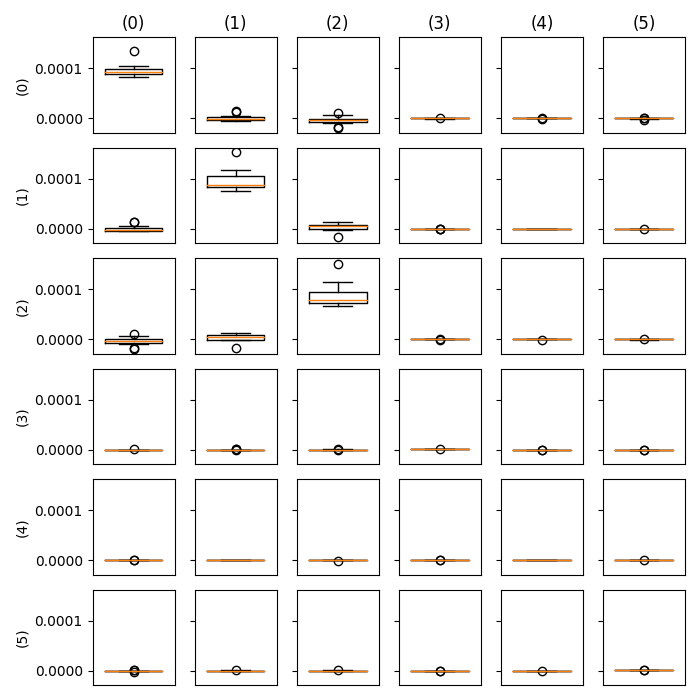

In [11]:
cov_list = np.array(cov_list)
# Create a grid of plots, where each boxplot is the element in the matrix
fig, axes = plt.subplots(cov_list.shape[1], cov_list.shape[2], figsize=(7, 7), sharey=True)
# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(cov_list.shape[1]):
    for j in range(cov_list.shape[2]):
        # Create the box plot for the data at position (i, j)
        data = [matrix[i, j] for matrix in cov_list]
        axes[i, j].boxplot(data, widths=0.7)
        if i == 0:
            axes[i, j].set_title(f'({j})')
        if j == 0:    
            axes[i, j].set_ylabel(f'({i})')
        axes[i, j].set_xticks([])  # Remove x-axis labels
plt.tight_layout()
plt.show()

# Get the average covariance matrix
final_r_covariance = np.mean(cov_list, axis=0)

In [12]:
# Create a dictionary of all the final calibration values
final_calibration = {
    'R': final_r_covariance.tolist(),
    'accelerometer_sensitivity': final_accelerometer_sensitivity,
    'accelerometer_offset': final_accelerometer_offset.tolist(),
    'gyroscope_offset': final_gyroscope_offset.tolist()
}
# Save the calibration values to a JSON file
with open('calibration.json', 'w') as f:
    json.dump(final_calibration, f, indent=4)


Offset norm: 0.1323810880842727
Mean norm: 9.803292010904991
RMS error: 0.030983636706520275
Mean error: -9.798909500761492e-05


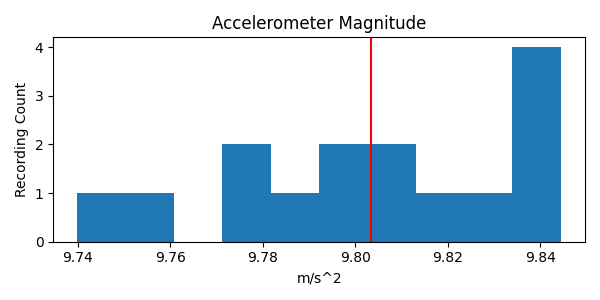

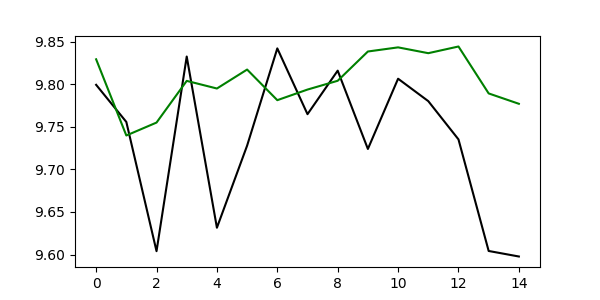

In [13]:
# Using the accelerometer offsets, let's plot a histogram of the norm of the accelerometer
adjusted_a_mean_list = np.array([np.linalg.norm(a_mean*final_accelerometer_sensitivity - final_accelerometer_offset) for a_mean in a_mean_list])
errors = adjusted_a_mean_list - TARGET_G

print(f"Offset norm: {np.linalg.norm(final_accelerometer_offset)}")
print(f"Mean norm: {np.mean(adjusted_a_mean_list)}")
print(f"RMS error: {np.sqrt(np.mean((errors)**2))}")
print(f"Mean error: {np.mean(errors)}")

# Plot a histogram of the norm of the accelerometer
plt.figure(figsize=(6, 3))
plt.hist(adjusted_a_mean_list, bins=10)
plt.axvline(TARGET_G, color='r', label='Target')
plt.title('Accelerometer Magnitude')
plt.xlabel('m/s^2')
plt.ylabel('Recording Count')
plt.tight_layout()
plt.show()

# Plot the errors using a line plot
plt.figure(figsize=(6, 3))
plt.plot([np.linalg.norm(a) for a in a_mean_list], 'k')
plt.plot(adjusted_a_mean_list, 'g')
plt.show()


Mean: [ 1.09865820e-18 -2.31296463e-19  1.85037171e-18]
RMS error: [1.45381453e-04 6.77631449e-05 4.65198158e-04]


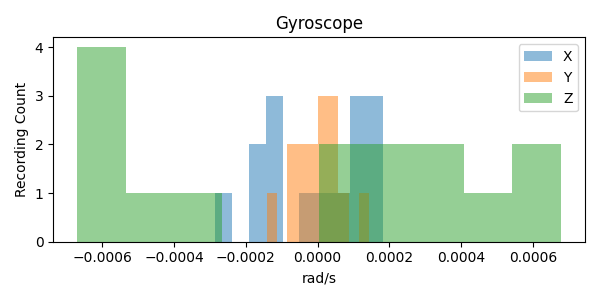

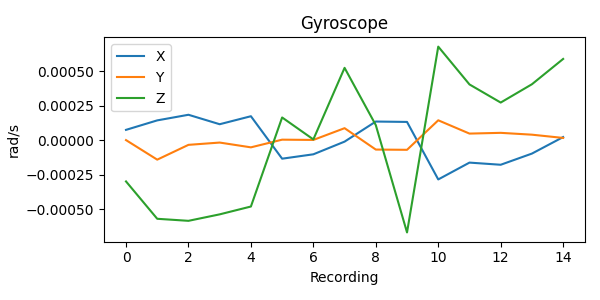

In [14]:
# Remove the gyroscope offset and plot the gyroscope data
adjusted_g_mean_list = np.array([g_mean - final_gyroscope_offset for g_mean in g_mean_list])


print(f'Mean: {np.mean(adjusted_g_mean_list, axis=0)}')
print(f"RMS error: {np.sqrt(np.mean((adjusted_g_mean_list)**2, axis=0))}")



# Plot the histogram
plt.figure(figsize=(6, 3))
plt.hist(adjusted_g_mean_list[:, 0], bins=10, label='X', alpha=0.5)
plt.hist(adjusted_g_mean_list[:, 1], bins=10, label='Y', alpha=0.5)
plt.hist(adjusted_g_mean_list[:, 2], bins=10, label='Z', alpha=0.5)
plt.title('Gyroscope')
plt.xlabel('rad/s')
plt.ylabel('Recording Count')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(adjusted_g_mean_list[:, 0], label='X')
plt.plot(adjusted_g_mean_list[:, 1], label='Y')
plt.plot(adjusted_g_mean_list[:, 2], label='Z')
plt.title('Gyroscope')
plt.xlabel('Recording')
plt.ylabel('rad/s')
plt.legend()
plt.tight_layout()
plt.show()